In [3]:
# для автозагрузки изменений в модулях без необходимости перезагрузки kelner
%load_ext autoreload
%autoreload 2

# необходимо для корректного импорта своих модулей в JupyterLab
import sys
current_dir = sys.path[0]
project_dir = 'SF_DS_Pro'
last_position = current_dir.find(project_dir) + len(project_dir)
project_path = current_dir[:last_position]
sys.path.append(project_path)

import Handlers as hd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
%matplotlib inline
plt.style.use('seaborn') #установка стиля matplotlib

Будем работать с датасетом из библиотеки sklearn о домах в Бостоне. 

Этот набор данных содержит информацию, собранную службой переписи населения США и касающуюся жилья в районе Бостона, штат Массачусетс.

Данный датасет содержится в модуле datasets библиотеки sklearn. 

Давайте загрузим датасет с помощью функции load_boston() и выведем его описание, обратившись по ключу 'DESCR':

In [5]:
from sklearn.datasets import load_boston 
boston = load_boston()
print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the 

В данном описании говорится, что у нас есть 506 участков с жилыми домами, которые описываются 13-ю признаками. 

На каждом из участков находится несколько домов. Измерены общие показатели по каждому из участков, в том числе медианная стоимость.

### Задача — научить модель предсказывать медианную стоимость дома на участке.

In [6]:
#создаём DataFrame из загруженных numpy-матриц
boston_data = pd.DataFrame(
    data=boston.data, #данные
    columns=boston.feature_names #наименования столбцов
)
#добавляем в таблицу столбец с целевой переменной
boston_data['MEDV'] = boston.target
boston_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [7]:
boston_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


In [8]:
corr_df = boston_data.corr().round(2)

<AxesSubplot:>

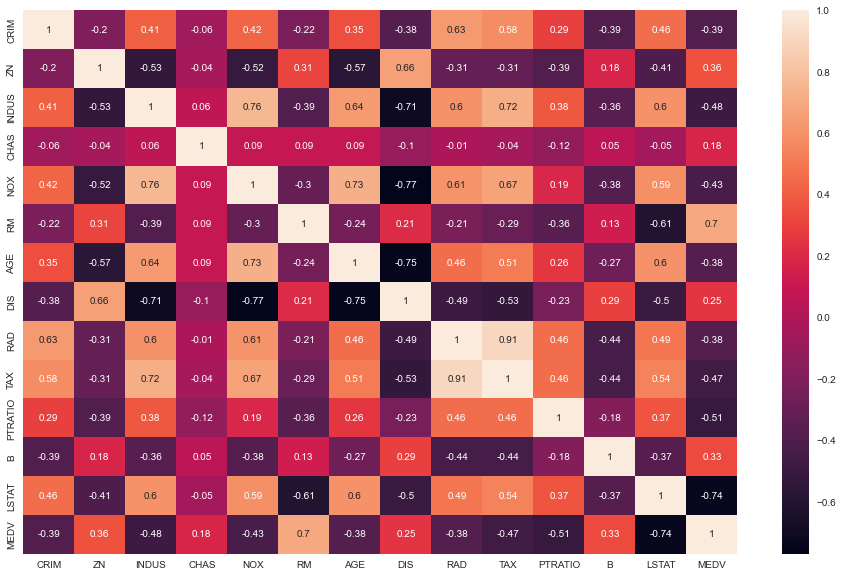

In [9]:
fig = plt.figure(figsize=(16, 10))
sns.heatmap(corr_df, annot=True)

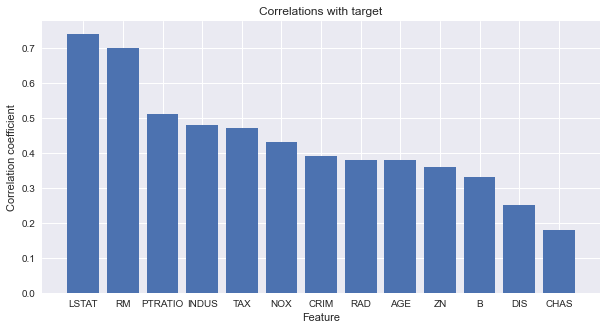

In [10]:
#Удаляем корреляцию целевой переменной с самой собой
corr_with_target = corr_df.abs()['MEDV'].sort_values(ascending=False).drop('MEDV')
#Строим столбчатую диаграмму корреляций
fig, ax = plt.subplots(figsize=(10, 5)) #фигура+координатная плоскость
ax.bar(corr_with_target.index, corr_with_target.values) #столбчатая диаграмма
ax.set_title('Correlations with target') #название графика
ax.set_xlabel('Feature') #название оси x
ax.set_ylabel('Сorrelation coefficient'); #название оси y

Построить линейную регрессию = обучить линейную регрессию = найти её параметры.

In [11]:
X = boston_data[['LSTAT']] # матрица наблюдений
y = boston_data['MEDV'] # вектор правильных ответов

In [12]:
print(X.shape)
print(y.shape)

(506, 1)
(506,)


In [13]:
X

,LSTAT
0,4.98
1,9.14
2,4.03
3,2.94
4,5.33
...,...
501,9.67
502,9.08
503,5.64
504,6.48


Матричное умножение в numpy реализуется с помощью оператора @. 

Транспонирование осуществляется через .T, а обратная матрица 

вычисляется с помощью функции inv() из модуля linalg (модуля для линейной алгебры).

In [14]:
def linear_regression(X, y):
    # Создаём вектор из единиц
    ones = np.ones(X.shape[0])
    # Добавляем вектор к таблице первым столбцом
    X = np.column_stack([ones, X])
    # Вычисляем обратную матрицу Q
    Q = np.linalg.inv(X.T @ X)
    # Вычисляем вектор коэффициентов
    w = Q @ X.T @ y
    return w

In [15]:
# Вычисляем параметры линейной регрессии
w = linear_regression(X, y)

# Выводим вычисленные значения параметров в виде вектора
print(f'Vector w: {w}')

# Выводим параметры с точностью до двух знаков после запятой
print(f'w0: {w[0]:.2f}')
print(f'w1: {w[1]:.2f}')

Vector w: [34.55384088 -0.95004935]
w0: 34.55
w1: -0.95


Теперь, если в данных появится новый участок 

Бостона с известной долей низкостатусного населения, 

мы сможем предсказать значение медианной стоимости домов простой подстановкой значений в модель:

In [16]:
# Задаём процент низкостатусного населения
x_example = 5.18

# Делаем предсказание
y_predict = w[0] + w[1] * x_example
print(f'Predicted value: {y_predict:.2f}')

Predicted value: 29.63


In [17]:
def plot_regression_2d(X, y_true, y_predict, xlabel='LSTAT', ylabel='MEDV'):
    fig, ax = plt.subplots(figsize=(14, 10)) # фигура + координатная плоскость
    ax.scatter(X, y_true, alpha=0.7, label='Sample data') # диаграмма рассеяния
    ax.plot(X, y_predict, color='black', label='Regression model') # линейный график
    ax.set_xlabel(xlabel) # название оси абсцисс
    ax.set_ylabel(ylabel) # название оси ординат
    ax.legend(facecolor='white', fontsize=11) # легенда

Сделаем предсказание для всех объектов из таблицы X,

подставив её в модель линейной регрессии с найденными параметрами, и построим график:

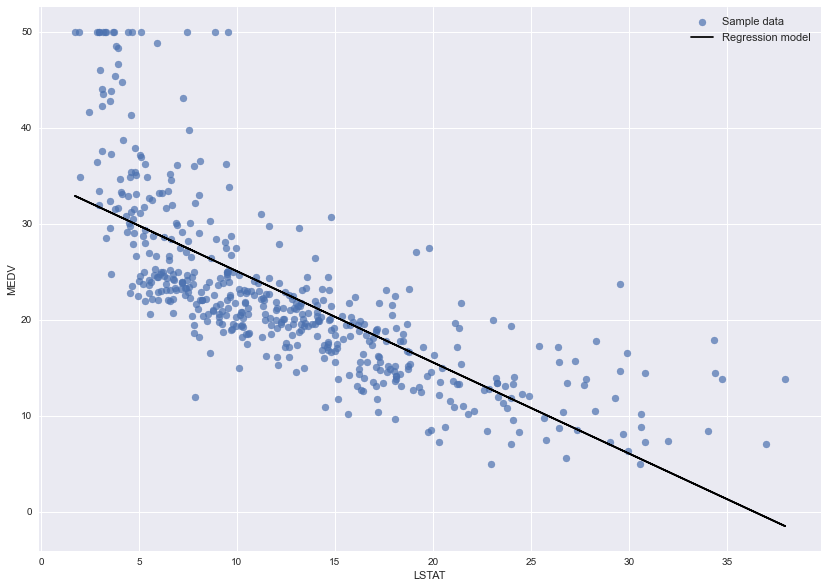

In [18]:
# Делаем предсказание для всех объектов из таблицы
y_predict = w[0] + w[1] * X

# Строим визуализацию
plot_regression_2d(X.to_numpy(), y, y_predict.to_numpy())

### АНАЛИТИЧЕСКОЕ РЕШЕНИЕ С ПОМОЩЬЮ SKLEARN

In [19]:
from sklearn import linear_model

In [20]:
# Создаём объект класса LinearRegression
lr_lstat = linear_model.LinearRegression()

# Обучаем модель — ищем параметры по МНК
lr_lstat.fit(X, y)
 
print(f'w0: {lr_lstat.intercept_}') #с вободный член w0
print(f'w1: {lr_lstat.coef_}') # остальные параметры модели w1, w2, ..., wm

w0: 34.5538408793831
w1: [-0.95004935]


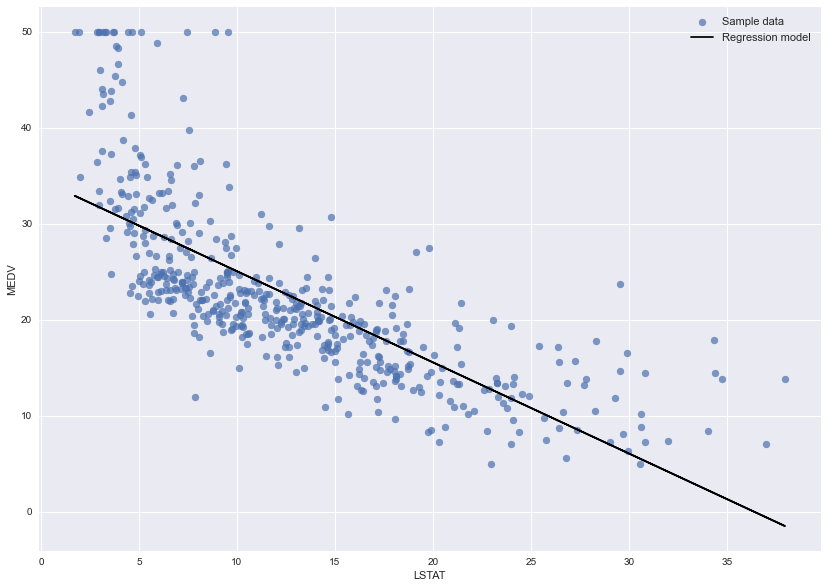

In [21]:
# Предсказываем медианную цену для всех участков из набора данных
y_predict = lr_lstat.predict(X)

# Строим визуализацию
plot_regression_2d(X.to_numpy(), y, y_predict)

Давайте выберем из таблицы boston все столбцы, исключая столбец с целевой переменной (MEDV). 

Полученную матрицу X и вектор правильных ответов y отправляем в метод fit(), чтобы произвести подгонку и найти параметры модели.

In [22]:
# Составляем список факторов (исключили целевой столбец)
features = boston_data.drop('MEDV', axis=1).columns
# Составляем матрицу наблюдений X и вектор ответов y
X = boston_data[features]
y = boston_data['MEDV']
# Создаём объект класса LinearRegression
lr_full = linear_model.LinearRegression()
# Обучаем модель — ищем параметры по МНК
lr_full.fit(X, y)

LinearRegression()

In [23]:
# Составляем таблицу из признаков и их коэффициентов
w_df = pd.DataFrame({'Features': features, 'Coefficients': lr_full .coef_})

# Составляем строку таблицы со свободным членом
intercept_df = pd.DataFrame({'Features': ['INTERCEPT'], 'Coefficients': lr_full .intercept_})
coef_df = pd.concat([w_df, intercept_df], ignore_index=True)
display(coef_df)

,Features,Coefficients
0,CRIM,-0.108011
1,ZN,0.046420
2,INDUS,0.020559
3,CHAS,2.686734
4,NOX,-17.766611
5,RM,3.809865
6,AGE,0.000692
7,DIS,-1.475567
8,RAD,0.306049
9,TAX,-0.012335


### Визуализируем ошибки

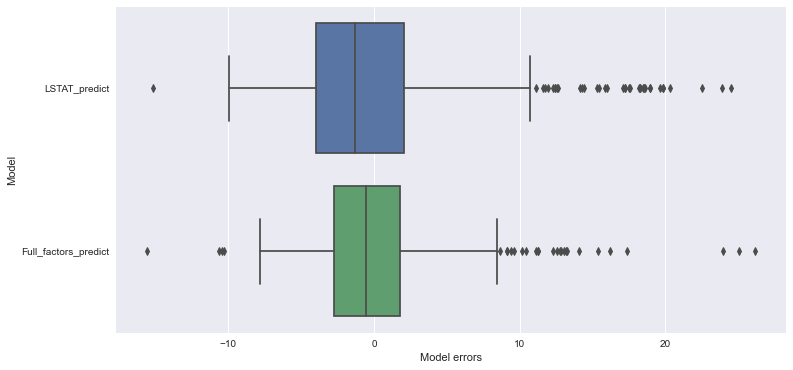

In [24]:
# Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6)) # фигура + координатная плоскость
# Ошибки модели на одном факторе LSTAT
y_errors_lstat = y - lr_lstat.predict(boston_data[['LSTAT']])
# Ошибки модели на всех факторах
y_errors_full = y - lr_full.predict(boston_data[features])
# Для удобства визуализации составим DataFrame из ошибок
errors_df = pd.DataFrame(
    {'LSTAT_predict': y_errors_lstat, 
     'Full_factors_predict': y_errors_full
    }
)
# Строим boxplot для ошибок
sns.boxplot(data=errors_df, orient='h', ax=ax)
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Model'); #название оси ординат

Сделайте предсказание медианной стоимости (MEDV) для данного участка c помощью модели lr_full. 

Введите результат предсказания в тысячах долларов. 

Ответ округлите до второго знака после точки-разделителя.

In [25]:
new_house = pd.DataFrame.from_dict({
    'CRIM': 0.35114,
    'ZN': 0.00000,
    'INDUS': 7.38000,
    'CHAS': 0.00000,
    'NOX': 0.49300,
    'RM': 6.04100,
    'AGE': 49.90000,
    'DIS': 4.72110,
    'RAD': 5.00000,
    'TAX': 287.00000,
    'PTRATIO': 19.60000,
    'B': 396.90000,
    'LSTAT': 7.70000
}, orient='index')

In [26]:
new_house = new_house.transpose()
new_house

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.35114,0.0,7.38,0.0,0.493,6.041,49.9,4.7211,5.0,287.0,19.6,396.9,7.7


In [27]:
round(lr_full.predict(new_house)[0], 2)

22.87

Дан набор данных о стартапах и их прибыли (в долларах) в трёх различных штатах США.

Столбцы:

R&D Spend — расходы на исследования.

Administration — административные расходы.

Marketing Spend — расходы на маркетинг.

State — штат.

Profit — прибыль (целевой признак).

Для обучения линейной регрессии используйте R&D Spend, 

Administration и Marketing Spend. Отделите факторы от целевой переменной.

Обучите модель линейной регрессии методом наименьших квадратов с помощью библиотеки numpy (воспользуйтесь формулой из модуля).

Чему равны коэффициенты линейной регрессии при признаках R&D Spend, 

Administration и Marketing Spend? 

Ответ введите с точностью до второго знака после точки-разделителя.

In [28]:
startups_df = pd.read_csv('data/50_Startups.zip')
startups_df

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94
5,131876.90,99814.71,362861.36,New York,156991.12
6,134615.46,147198.87,127716.82,California,156122.51
7,130298.13,145530.06,323876.68,Florida,155752.60
8,120542.52,148718.95,311613.29,New York,152211.77
9,123334.88,108679.17,304981.62,California,149759.96


In [29]:
startups_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [30]:
# Категориальный признак Штата убираю
startups_df.drop('State', axis=1, inplace=True)

In [28]:
features = startups_df.columns[:-1]

In [29]:
X = startups_df[features]

In [30]:
y = startups_df['Profit']

In [31]:
def linear_regression(X, y):
    # Создаём вектор из единиц
    ones = np.ones(X.shape[0])
    # Добавляем вектор к таблице первым столбцом
    X = np.column_stack([ones, X])
    # Вычисляем обратную матрицу Q
    Q = np.linalg.inv(X.T @ X)
    # Вычисляем вектор коэффициентов
    w = Q @ X.T @ y
    return w

In [32]:
w = linear_regression(X, y)

In [33]:
w

array([ 5.01221930e+04,  8.05715050e-01, -2.68159684e-02,  2.72280648e-02])

In [34]:
# Первый коэфф исключаю, т.к. это intercept_
w[1:]

array([ 0.80571505, -0.02681597,  0.02722806])

In [35]:
startups_df.columns[:-1]

Index(['R&D Spend', 'Administration', 'Marketing Spend'], dtype='object')

In [36]:

coef_df = pd.DataFrame(w[1:], index=features, columns=['w'])

In [37]:
coef_df.round(2)

,w
R&D Spend,0.81
Administration,-0.03
Marketing Spend,0.03


### РАСЧЁТ МЕТРИК НА PYTHON

In [38]:
from sklearn import metrics

### Модель только по LSTAT

In [39]:
X = boston_data[['LSTAT']] # матрица наблюдений
y = boston_data['MEDV'] # вектор правильных ответов

In [40]:
# Делаем предсказание по признаку LSTAT
lr_lstat.fit(X, y)
y_predict_lstat = lr_lstat.predict(X)

# Рассчитываем MAE
print(f'MAE score: {metrics.mean_absolute_error(y, y_predict_lstat):.3f} thou. $')

# Рассчитываем RMSE
print(f'RMSE score: {np.sqrt(metrics.mean_squared_error(y, y_predict_lstat)):.3f} thou. $')

# Рассчитываем MAPE
print(f'MAPE score: {metrics.mean_absolute_percentage_error(y, y_predict_lstat) * 100:.3f} %')

# Рассчитываем коэффициент детерминации
print(f'R2 score: {metrics.r2_score(y, y_predict_lstat):.3f}')

MAE score: 4.505 thou. $
RMSE score: 6.203 thou. $
MAPE score: 21.352 %
R2 score: 0.544


### Модель по всем признакам

In [41]:
features = boston.feature_names
X = boston_data[features] # матрица наблюдений
y = boston_data['MEDV'] # вектор правильных ответов

In [42]:
# Делаем предсказание по всем признакам
lr_lstat.fit(X, y)
y_predict_lstat = lr_lstat.predict(X)

In [43]:
# Рассчитываем MAE
print(f'MAE score: {metrics.mean_absolute_error(y, y_predict_lstat):.3f} thou. $')

# Рассчитываем RMSE
print(f'RMSE score: {np.sqrt(metrics.mean_squared_error(y, y_predict_lstat)):.3f} thou. $')

# Рассчитываем MAPE
print(f'MAPE score: {metrics.mean_absolute_percentage_error(y, y_predict_lstat) * 100:.3f} %')

# Рассчитываем коэффициент детерминации
print(f'R2 score: {metrics.r2_score(y, y_predict_lstat):.3f}')

MAE score: 3.271 thou. $
RMSE score: 4.679 thou. $
MAPE score: 16.417 %
R2 score: 0.741


У вас есть истинные ответы y_true = [1.23, 2.35, 2.75] 

и предсказания модели y_pred = [1.01, 12.3, 2.74]. 

Посчитайте метрику RMSE, ответ округлите до двух знаков после точки-разделителя.

### Расчет RMSE вручную

In [44]:
y_true = [1.23, 2.35, 2.75]
y_pred = [1.01, 12.3, 2.74]

In [60]:
# Преобразую в numpy массивы
y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [61]:
MSE = np.sum(np.square(y_true - y_pred)) / len(y_true)

In [62]:
RMSE = round(np.sqrt(MSE), 2)

In [63]:
RMSE

5.75

### Расчет RMSE с помощью библиотеки sqlearn

In [64]:
y_true = [1.23, 2.35, 2.75]
y_pred = [1.01, 12.3, 2.74]

In [65]:
MSE = metrics.mean_squared_error(y_true, y_pred)

33.01700000000001

In [66]:
RMSE = round(np.sqrt(MSE), 2)

In [67]:
RMSE

5.75

Чему равен коэффициент детерминации на следующих данных?

Истинные ответы: y_true = [22.4, 20.6, 23.9, 22.0, 11.9]

Предсказанные ответы: y_pred = [20.5, 20.2, 20.3, 19.0, 11.0]

In [68]:
y_true = [22.4, 20.6, 23.9, 22.0, 11.9]
y_pred = [20.5, 20.2, 20.3, 19.0, 11.0]

In [69]:
round(metrics.r2_score(y_true, y_pred), 2)

0.71